# LTE IQ Analizi — 10 MHz, 5 ms

Bu slayt tarzı not defteri, `LTEIQ.raw` dosyasından LTE yayın (broadcast) parametrelerini tek dokunuşla çıkarır ve adım adım ara sonuçları gösterir.

## Amaç
- NDLRB, DuplexMode, CyclicPrefix
- NCellID (PCI), NSubframe
- MIB üzerinden: CellRefP, PHICHDuration, Ng, NFrame

In [1]:
# Ortam ve proje içe aktarımları
from pathlib import Path
import sys
ROOT = Path.cwd().resolve().parents[0]  # notebooks/..
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.lte_params import (
    LTEConfig, read_iq_file, analyze_lte_iq, pretty_print_results,
    detect_pss_across_slots, symbol_starts_for_subframe, cp_lengths_normal, fft_symbol,
)
from src.pbch import (
    extract_pbch_re, estimate_common_phase, apply_phase, normalize_amplitude,
    try_decode_mib_from_pbch, brute_force_mib_from_pbch
)

cfg = LTEConfig()
iq_path = ROOT / 'LTEIQ.raw'
assert iq_path.exists(), 'LTEIQ.raw dosyası bulunamadı'
x = read_iq_file(str(iq_path))
len(x), cfg.nfft, cfg.subframe_samples

(76800, 1024, 15360)

## Hızlı Sonuçlar

In [2]:
res = analyze_lte_iq(x, cfg)
print(pretty_print_results(res))
res

NDLRB: 15
DuplexMode: FDD
CyclicPrefix: Normal
NCellID: 7
NSubframe: 0
CellRefP: 2
PHICHDuration: Extended
Ng: 1/2
NFrame: 109


{'NDLRB': 15,
 'CyclicPrefix': 'Normal',
 'PSS_metric': 0.3084973949235857,
 'NID2': 1,
 'Estimated_CFO_rad_per_sample': np.float32(-0.0009730528),
 'SSS_metric': 0.23380639393085326,
 'NID1': 144,
 'DuplexMode': 'FDD',
 'NSubframe': 0,
 'NCellID': 7,
 'CellRefP': 2,
 'PHICHDuration': 'Extended',
 'Ng': '1/2',
 'NFrame': 109,
 'Note': 'PBCH/MIB decoded (best-effort with brute-force)'}

## Detay 1 — PSS (NID2), Zamanlama ve CFO

In [3]:
pss = detect_pss_across_slots(x, cfg)
pss

{'slot_index': 3,
 'symbol_index': 27,
 'nid2': 1,
 'metric': 0.3084973949235857,
 'cfo': np.float32(-0.0009730528)}

## Detay 2 — SSS (NID1), Duplex ve Subframe

In [4]:
# PSS'in bulunduğu slotun bir önceki sembolünden SSS tespiti
subframe_idx = (int(pss['slot_index']) // 2) if pss['slot_index'] is not None else 0
sym_starts = symbol_starts_for_subframe(cfg, subframe_idx * cfg.subframe_samples)
cp_vec = cp_lengths_normal(cfg)
local_last = 6 if (int(pss['slot_index']) % 2 == 0) else 13
sss_local = local_last - 1
F_sss = fft_symbol(x, sym_starts[sss_local], int(cp_vec[sss_local]), cfg.nfft, float(pss.get('cfo',0.0)))
from src.lte_params import sss_detect_in_symbol
nid1, m_sss, is_sf0, is_fdd = sss_detect_in_symbol(F_sss, cfg.nfft, int(pss['nid2']))
{
 'NID1': nid1,
 'SSS_metric': m_sss,
 'DuplexMode': 'FDD' if is_fdd else 'TDD',
 'NSubframe': 0 if is_sf0 else 5,
 'NCellID': (3*int(nid1)+int(pss['nid2'])) if nid1 is not None else None
}

{'NID1': 144,
 'SSS_metric': 0.23380639393085326,
 'DuplexMode': 'FDD',
 'NSubframe': 0,
 'NCellID': 433}

## Detay 3 — PBCH ve MIB (CellRefP, PHICH, Ng, NFrame)

In [5]:
# PBCH RE çıkarımı ve eşitleme
pbch_re = extract_pbch_re(x, cfg, 0, 0.0)
theta = estimate_common_phase(pbch_re)
pbch_eq = normalize_amplitude(apply_phase(pbch_re, theta))
# Önce tahmini NCellID ile, olmazsa brute-force (NID2 kısıtlı)
try_first = try_decode_mib_from_pbch(pbch_eq, int((3*nid1+pss['nid2']) if nid1 is not None else res.get('NCellID') or 0))
final_mib = try_first or brute_force_mib_from_pbch(pbch_eq, res.get('NCellID'), res.get('NID2'))
final_mib

{'CellRefP': 2,
 'PHICHDuration': 'Extended',
 'Ng': '1/2',
 'NFrame': 109,
 'NDLRB_from_MIB': 15,
 'NCellID': 7}

## TDD Özel: Alt Çerçeve 1 (Special Subframe)

TDD için, alt çerçeve 1 tipik olarak ‘special subframe’ (DwPTS+GP+UpPTS) içerir.
Aşağıda merkez 62 taşıyıcı enerji oranına dayalı bir heuristik gösterilir.

In [6]:
# TDD ise özel alt çerçeve 1 tespiti
from src.lte_params import detect_tdd_special_subframe
if res.get('DuplexMode') == 'TDD':
    tdd_info = detect_tdd_special_subframe(x, cfg)
    tdd_info
else:
    {'Note': 'FDD modunda özel alt çerçeve yoktur.'}

## TDD Yapılandırma (UL-DL Config 0..6) — Heuristik

In [7]:
# İlk 5 alt çerçevede (0..4) merkez bant enerjilerine bakarak UL/DL tahmini ve config skoru
from src.lte_params import detect_tdd_config
if res.get('DuplexMode') == 'TDD':
    cfg_info = detect_tdd_config(x, cfg)
    cfg_info
else:
    {'Note': 'FDD modunda TDD config uygulanmaz.'}

## Görseller — Enerji Isı Haritası

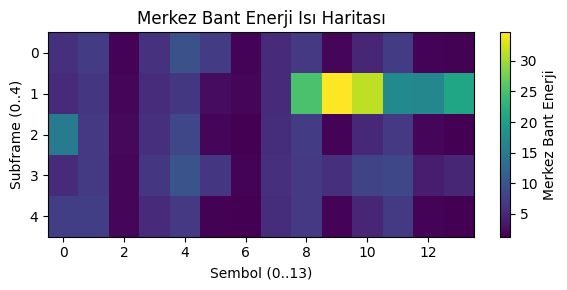

In [8]:
# İlk 5 alt çerçevede sembol başına merkez bant enerji ısı haritası
import numpy as np
import matplotlib.pyplot as plt
from src.lte_params import compute_center_energy_matrix
E = compute_center_energy_matrix(x, cfg, subframes=5)
plt.figure(figsize=(6,3))
plt.imshow(E, aspect='auto', cmap='viridis')
plt.colorbar(label='Merkez Bant Enerji')
plt.ylabel('Subframe (0..4)')
plt.xlabel('Sembol (0..13)')
plt.title('Merkez Bant Enerji Isı Haritası')
plt.tight_layout()
plt.show()

## Görseller — PSS Korelasyon Profili

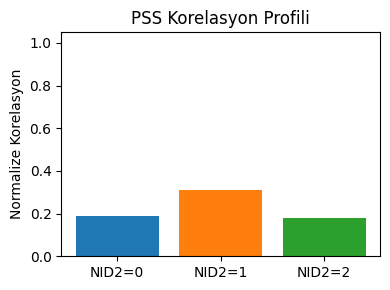

In [9]:
# PSS için NID2∈{0,1,2} korelasyon değerlerini görselleştir
import numpy as np
import matplotlib.pyplot as plt
from src.lte_params import generate_pss_fd

slot = int(pss['slot_index']) if pss.get('slot_index') is not None else 0
# Slotun son sembolünün FFT'sini tekrar alalım
subframe_idx = (slot // 2)
subframe_start = subframe_idx * cfg.subframe_samples
sym_starts = symbol_starts_for_subframe(cfg, subframe_start)
cp_vec = cp_lengths_normal(cfg)
local_last = 6 if (slot % 2) == 0 else 13
F_last = fft_symbol(x, sym_starts[local_last], int(cp_vec[local_last]), cfg.nfft, float(pss.get('cfo',0.0)))

dc = cfg.nfft // 2
obs = np.concatenate([F_last[dc-31:dc], F_last[dc+1:dc+32]])
metrics = []
for nid2 in (0,1,2):
    ref = generate_pss_fd(cfg.nfft, nid2)
    ref_bins = np.concatenate([ref[dc-31:dc], ref[dc+1:dc+32]])
    num = np.vdot(ref_bins, obs)
    den = (np.linalg.norm(ref_bins) * np.linalg.norm(obs) + 1e-12)
    metrics.append(abs(num)/den)
plt.figure(figsize=(4,3))
plt.bar([0,1,2], metrics, color=['C0','C1','C2'])
plt.xticks([0,1,2], ['NID2=0','NID2=1','NID2=2'])
plt.ylabel('Normalize Korelasyon')
plt.title('PSS Korelasyon Profili')
plt.ylim(0,1.05)
plt.tight_layout()
plt.show()

## Görseller — SSS Korelasyon Tepe Değerleri

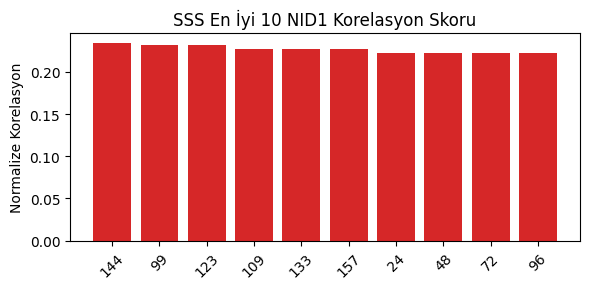

In [10]:
# SSS için NID1∈[0..167] korelasyonlarından en iyi 10 tanesini çizelim
import numpy as np
import matplotlib.pyplot as plt
from src.lte_params import generate_sss_fd

dc = cfg.nfft // 2
# Önceden hesaplanan F_sss'i tekrar oluşturalım
slot = int(pss['slot_index']) if pss.get('slot_index') is not None else 0
subframe_idx = (slot // 2)
sym_starts = symbol_starts_for_subframe(cfg, subframe_idx * cfg.subframe_samples)
cp_vec = cp_lengths_normal(cfg)
local_last = 6 if (slot % 2) == 0 else 13
sss_local = local_last - 1
Fsss = fft_symbol(x, sym_starts[sss_local], int(cp_vec[sss_local]), cfg.nfft, float(pss.get('cfo',0.0)))
obs = np.concatenate([Fsss[dc-31:dc], Fsss[dc+1:dc+32]])
# FDD/TDD ve subframe0/5 varsayımlarını önceki hücreden alalım
assume_fdd = bool(is_fdd)
assume_sf0 = bool(is_sf0)
vals = []
for nid1_c in range(168):
    ref = generate_sss_fd(cfg.nfft, nid1_c, int(pss['nid2']), assume_sf0, assume_fdd)
    ref_bins = np.concatenate([ref[dc-31:dc], ref[dc+1:dc+32]])
    num = np.vdot(ref_bins, obs)
    den = (np.linalg.norm(ref_bins) * np.linalg.norm(obs) + 1e-12)
    vals.append((nid1_c, float(abs(num)/den)))
vals.sort(key=lambda t: t[1], reverse=True)
TOP=10
ids=[v[0] for v in vals[:TOP]]
sc=[v[1] for v in vals[:TOP]]
plt.figure(figsize=(6,3))
plt.bar(range(TOP), sc, color='C3')
plt.xticks(range(TOP), [str(i) for i in ids], rotation=45)
plt.ylabel('Normalize Korelasyon')
plt.title('SSS En İyi 10 NID1 Korelasyon Skoru')
plt.tight_layout()
plt.show()

## Görseller — PBCH Merkez 6 RB Spektrumu

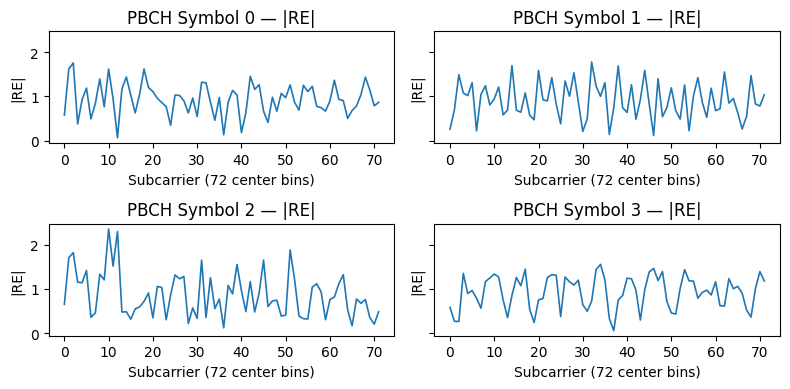

In [11]:
# PBCH eşitlenmiş RE'lerde (4,72) mutlak değer profili
import numpy as np
import matplotlib.pyplot as plt

# Eğer önceki hücre çalıştıysa pbch_eq hazır; değilse tekrar oluştur
try:
    pbch_eq
except NameError:
    pbch_re = extract_pbch_re(x, cfg, 0, 0.0)
    theta = estimate_common_phase(pbch_re)
    pbch_eq = normalize_amplitude(apply_phase(pbch_re, theta))

fig, axes = plt.subplots(2,2, figsize=(8,4), sharey=True)
axes = axes.ravel()
for i in range(4):
    axes[i].plot(np.abs(pbch_eq[i]), lw=1.2)
    axes[i].set_title(f'PBCH Symbol {i} — |RE|')
    axes[i].set_xlabel('Subcarrier (72 center bins)')
    axes[i].set_ylabel('|RE|')
plt.tight_layout()
plt.show()

## Özet

In [12]:
# Hızlı çıktıyı slayt görünümünde göster
print(pretty_print_results(res))

NDLRB: 15
DuplexMode: FDD
CyclicPrefix: Normal
NCellID: 7
NSubframe: 0
CellRefP: 2
PHICHDuration: Extended
Ng: 1/2
NFrame: 109


Notlar:
- Tek 5 ms veri ile PBCH/MIB çözümü brute-force desteklidir; SNR ve hizalama sonuçları etkileyebilir.
- SSS/PSS tespiti üzerinden NCellID doğrulanır; PBCH çözülürse MIB alanları doldurulur.
- TDD özel alt çerçeve tespiti merkez bant enerji oranına dayanır (sunum amaçlı heuristik).

## Görseller — Zaman Alanı Genliği (İlk Alt Çerçeve)

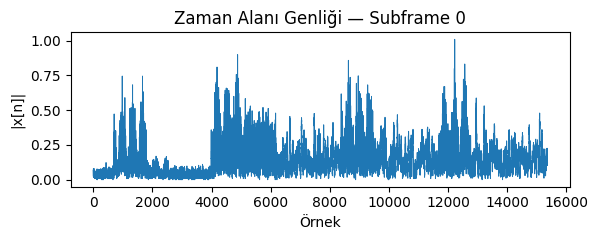

In [13]:
# İlk alt çerçeveden örneklerin genliği
import numpy as np
import matplotlib.pyplot as plt
N = cfg.subframe_samples
seg = x[:N]
plt.figure(figsize=(6,2.5))
plt.plot(np.abs(seg), lw=0.7)
plt.title('Zaman Alanı Genliği — Subframe 0')
plt.xlabel('Örnek')
plt.ylabel('|x[n]|')
plt.tight_layout()
plt.show()

## Görseller — PSS Sembolü Spektrum Genliği

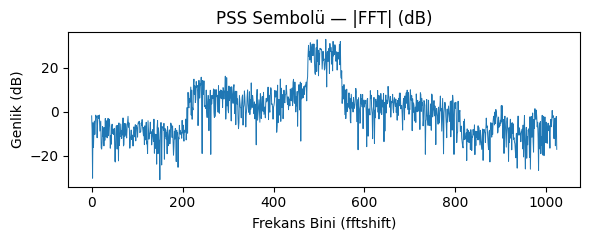

In [14]:
# PSS'in bulunduğu slotun son sembolünde spektrum genliği
import numpy as np
import matplotlib.pyplot as plt
slot = int(pss['slot_index']) if pss.get('slot_index') is not None else 0
subframe_idx = (slot // 2)
sym_starts = symbol_starts_for_subframe(cfg, subframe_idx * cfg.subframe_samples)
cp_vec = cp_lengths_normal(cfg)
local_last = 6 if (slot % 2) == 0 else 13
F = fft_symbol(x, sym_starts[local_last], int(cp_vec[local_last]), cfg.nfft, float(pss.get('cfo',0.0)))
plt.figure(figsize=(6,2.5))
plt.plot(20*np.log10(np.abs(F)+1e-9), lw=0.7)
plt.title('PSS Sembolü — |FFT| (dB)')
plt.xlabel('Frekans Bini (fftshift)')
plt.ylabel('Genlik (dB)')
plt.tight_layout()
plt.show()

## Görseller — CFO (Sembol Bazında, Subframe 0)

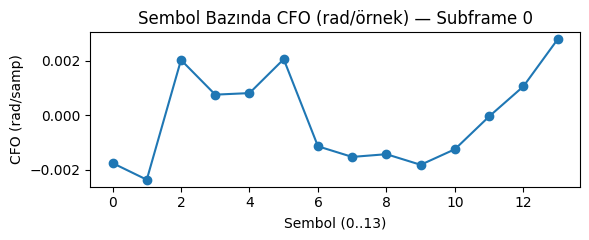

In [15]:
# Subframe 0'da sembol bazında kaba CFO tahmini
import numpy as np
import matplotlib.pyplot as plt
from src.lte_params import coarse_cfo_estimate
starts = symbol_starts_for_subframe(cfg, 0)
cp_vec = cp_lengths_normal(cfg)
cfo_sym = []
for l in range(cfg.symbols_per_slot*cfg.slots_per_subframe):
    seg = x[starts[l]:starts[l]+int(cp_vec[l])+cfg.nfft]
    cfo_sym.append(coarse_cfo_estimate(seg, int(cp_vec[l]), cfg.nfft))
plt.figure(figsize=(6,2.5))
plt.plot(cfo_sym, marker='o')
plt.title('Sembol Bazında CFO (rad/örnek) — Subframe 0')
plt.xlabel('Sembol (0..13)')
plt.ylabel('CFO (rad/samp)')
plt.tight_layout()
plt.show()

## Görseller — Slot Bazında PSS Korelasyon Skoru

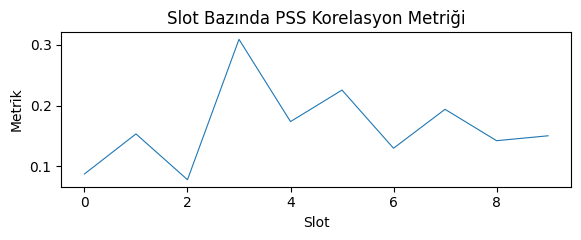

In [16]:
# Tüm slotların son sembolünde PSS korelasyon metriği
import numpy as np
import matplotlib.pyplot as plt
from src.lte_params import pss_detect_in_symbol
metrics=[]
slots = len(x)//cfg.slot_samples
for s in range(slots):
    # slot son sembolünün başlangıcı
    slot_start = s*cfg.slot_samples
    sym_start = slot_start
    for l in range(6):
        sym_start += cfg.cp_slot[l] + cfg.nfft
    F = fft_symbol(x, sym_start, cfg.cp_slot[6], cfg.nfft, 0.0)
    nid2, m = pss_detect_in_symbol(F, cfg.nfft)
    metrics.append(m)
plt.figure(figsize=(6,2.5))
plt.plot(metrics, lw=0.8)
plt.title('Slot Bazında PSS Korelasyon Metriği')
plt.xlabel('Slot')
plt.ylabel('Metri̇k')
plt.tight_layout()
plt.show()

## Görseller — NID1 Korelasyon Eğrisi (0..167)

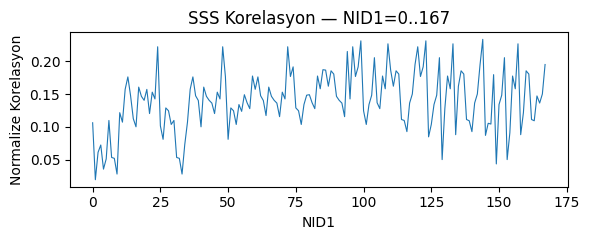

In [17]:
# NID1 için tam korelasyon eğrisi (seçilen FDD/TDD, SF0/5 hipoteziyle)
import numpy as np
import matplotlib.pyplot as plt
from src.lte_params import generate_sss_fd
dc = cfg.nfft//2
obs = np.concatenate([F_sss[dc-31:dc], F_sss[dc+1:dc+32]])
vals=[]
for nid1_c in range(168):
    ref = generate_sss_fd(cfg.nfft, nid1_c, int(pss['nid2']), bool(is_sf0), bool(is_fdd))
    ref_bins = np.concatenate([ref[dc-31:dc], ref[dc+1:dc+32]])
    num = np.vdot(ref_bins, obs)
    den = (np.linalg.norm(ref_bins)*np.linalg.norm(obs)+1e-12)
    vals.append(abs(num)/den)
plt.figure(figsize=(6,2.5))
plt.plot(vals, lw=0.8)
plt.title('SSS Korelasyon — NID1=0..167')
plt.xlabel('NID1')
plt.ylabel('Normalize Korelasyon')
plt.tight_layout()
plt.show()

## Görseller — PBCH Eşitlenmiş Semboller (Küme Saçılımı)

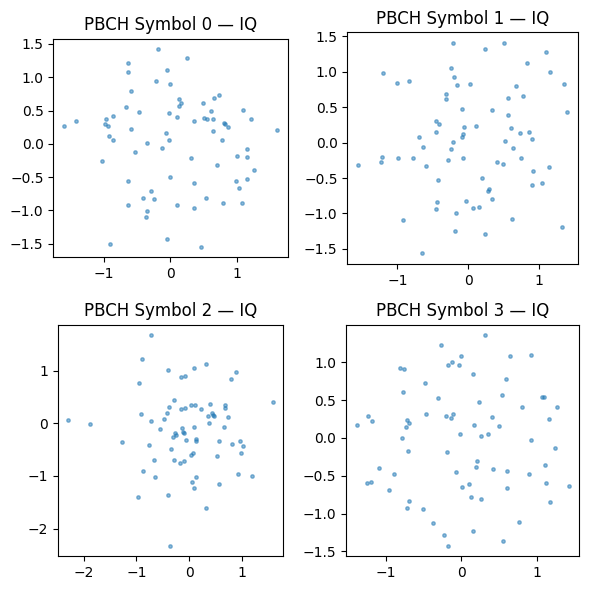

In [18]:
# PBCH eşitlenmiş QPSK sembollerinin saçılımı
import numpy as np
import matplotlib.pyplot as plt
try:
    pbch_eq
except NameError:
    pbch_re = extract_pbch_re(x, cfg, 0, 0.0)
    theta = estimate_common_phase(pbch_re)
    pbch_eq = normalize_amplitude(apply_phase(pbch_re, theta))
fig, axes = plt.subplots(2,2, figsize=(6,6))
axes = axes.ravel()
for i in range(4):
    z = pbch_eq[i].ravel()
    axes[i].scatter(z.real, z.imag, s=6, alpha=0.5)
    axes[i].set_aspect('equal')
    axes[i].set_title(f'PBCH Symbol {i} — IQ')
plt.tight_layout()
plt.show()

## Görseller — CRS Maskesi (PBCH 4×72)

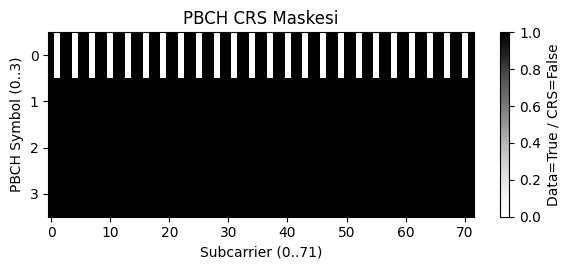

In [19]:
# PBCH'te veri/CRS maskesini görselleştir (True=data, False=CRS)
import numpy as np
import matplotlib.pyplot as plt
from src.pbch import crs_data_mask_for_pbch
mask = crs_data_mask_for_pbch(int(res.get('NCellID') or 0), cellrefp=2)
plt.figure(figsize=(6,2.8))
plt.imshow(mask, aspect='auto', cmap='Greys')
plt.colorbar(label='Data=True / CRS=False')
plt.xlabel('Subcarrier (0..71)')
plt.ylabel('PBCH Symbol (0..3)')
plt.title('PBCH CRS Maskesi')
plt.tight_layout()
plt.show()

## Görseller — PBCH LLR Histogramı

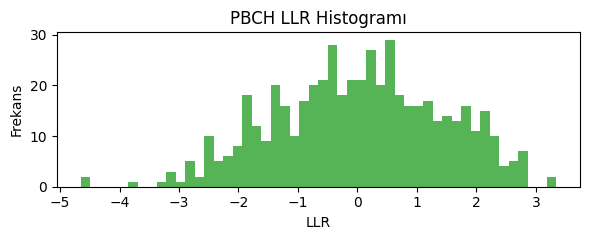

In [20]:
# PBCH veri RE'lerinden LLR dağılımı
import numpy as np
import matplotlib.pyplot as plt
from src.pbch import qpsk_llrs
mask = crs_data_mask_for_pbch(int(res.get('NCellID') or 0), cellrefp=2)
data_re = pbch_eq[mask].reshape(-1)
ll = qpsk_llrs(data_re, noise_var=1.0)
plt.figure(figsize=(6,2.5))
plt.hist(ll, bins=50, color='C2', alpha=0.8)
plt.title('PBCH LLR Histogramı')
plt.xlabel('LLR')
plt.ylabel('Frekans')
plt.tight_layout()
plt.show()

## Görseller — De‑rate Match Sonrası 120 LLR Profili

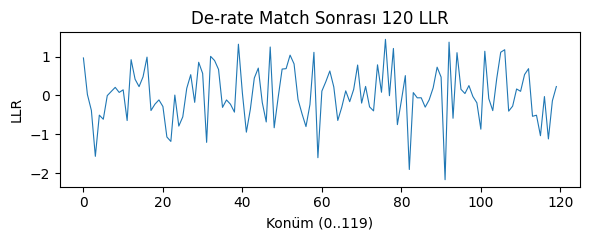

In [21]:
# 480->120 de‑rate match sonrası LLR'ler (i_mod4=0 varsayımıyla)
import numpy as np
import matplotlib.pyplot as plt
from src.pbch import deratematch_pbch_llrs
ll120 = None
try:
    # basit üretim: ilk 480 yumuşak bitlerden 120'ye indirgeme
    ll480 = ll[:480]
    ll120 = deratematch_pbch_llrs(ll480, 0)
except Exception:
    pass
if ll120 is not None:
    plt.figure(figsize=(6,2.5))
    plt.plot(ll120, lw=0.8)
    plt.title('De‑rate Match Sonrası 120 LLR')
    plt.xlabel('Konüm (0..119)')
    plt.ylabel('LLR')
    plt.tight_layout()
    plt.show()
else:
    print('LLR120 üretilemedi (yetersiz veri)')

## Görseller — Alt Çerçeve Enerjileri (0..4)

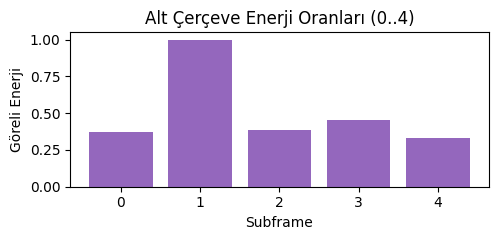

In [22]:
# Alt çerçeve başına merkez-bant enerji çubuk grafiği
import numpy as np
import matplotlib.pyplot as plt
from src.lte_params import compute_center_energy_matrix
E = compute_center_energy_matrix(x, cfg, subframes=5)
rat = E.mean(axis=1)
rat = rat/rat.max()
plt.figure(figsize=(5,2.5))
plt.bar(range(5), rat, color='C4')
plt.title('Alt Çerçeve Enerji Oranları (0..4)')
plt.xlabel('Subframe')
plt.ylabel('Göreli Enerji')
plt.ylim(0,1.05)
plt.tight_layout()
plt.show()